<h2> Library Import </h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import multiprocessing
from collections import Counter
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from collections import namedtuple
from bs4 import BeautifulSoup
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

<h2> Load Dataset </h2>

In [2]:
train = pd.read_csv('NewsCategorization/Data_Train.csv',encoding='cp1252')
test = pd.read_csv('NewsCategorization/Data_Test.csv',encoding='cp1252')

In [3]:
print('Jumlah Train: ',np.shape(train)[0])
print('Jumlah Test: ',np.shape(test)[0])
print('Total',np.shape(train)[0]+np.shape(test)[0])

Jumlah Train:  7628
Jumlah Test:  2748
Total 10376


3    1246
0    1686
2    1924
1    2772
Name: SECTION, dtype: int64


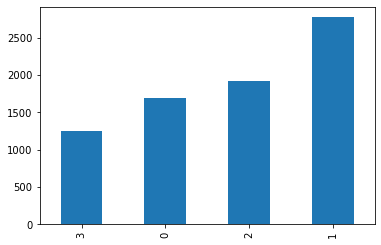

In [4]:
train['SECTION'].value_counts().sort_values().plot(kind = 'bar')
print(train['SECTION'].value_counts().sort_values())

<h2> Preprocessing  Function </h2>

Tujuan preprocessing ini adalah untuk "membersihkan" data dari huruf/karakter yang tidak diinginkan sehingga output dari data yang baru adalah hanya berupa kalimatnya saja.

In [5]:
def text_preprocess(text):
    text = text.replace('\n',' ')
    text = re.sub('[~`!@#$%^&*():;"{}_/?><\|.,`0-9]', '', text)
    text = text.replace('  ',' ')
    text = text.replace("'","")
    text = text.replace('’','')
    text = ''.join([i for i in text if not i.isdigit()])
    return text

<h2> Obtaining Vector Function </h2>

Fungsi dibawah ini mengambil vektor dari hasil pembangunan vocabulary dari vector space model.

In [6]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=5)) for doc in sents])
    return regressors,targets

Lakukan preprocessing terhadap dataset:

In [7]:
train['STORY'] = train['STORY'].apply(text_preprocess)

In [8]:
test['STORY'] = test['STORY'].apply(text_preprocess)

<h2> List / Document Assignment </h2>

Proses dibawah ini adalah melakukan penyimpanan dataset bertipe objek/dokumen dan melakukan tokenisasi kata.

In [9]:
dTrain = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for i in range(len(train)):
    words = word_tokenize(str(train['STORY'][i]).lower())
    tags = [train['SECTION'][i]]
    dTrain.append(analyzedDocument(words, tags))
dTrain = pd.Series(dTrain)

In [10]:
dTest = []
analyzedDocument2 = namedtuple('AnalyzedDocument2', 'words tags')
for i in range(len(test)):
    words = word_tokenize(str(test['STORY'][i]).lower())
    tags = [i]
    dTest.append(analyzedDocument2(words, tags))
dTest = pd.Series(dTest)

<h2> Building Vocabulary of Train Data </h2>

Proses membangun vocabulary dari data train dengan mengeset jumlah epoch (iterasi) sebanyak 20, dimensi vektor sebanyak 5, dan minimum alpha sebanyak 0.0025 dan alpha awal sebesar 0.025.

In [11]:
max_epochs = 20
vec_size = 5
alpha = 0.025
model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.0025,
                min_count=5,
                dm =1)
  
model.build_vocab(dTrain)

/Users/faoezanf/opt/anaconda3/envs/env1/lib/python3.6/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


<h2> Training Vector Space Model </h2>

Proses training dengan mereduksi alpha sebesar 0.0002 untuk setiap iterasinya.

In [12]:
for epoch in range(max_epochs):
    print('Iterasi : {0}'.format(epoch))
    model.train(dTrain,
                total_examples=model.corpus_count,
                epochs=model.iter)

    model.alpha -= 0.0002

    model.min_alpha = model.alpha

Iterasi : 0


/Users/faoezanf/opt/anaconda3/envs/env1/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


Iterasi : 1
Iterasi : 2
Iterasi : 3
Iterasi : 4
Iterasi : 5
Iterasi : 6
Iterasi : 7
Iterasi : 8
Iterasi : 9
Iterasi : 10
Iterasi : 11
Iterasi : 12
Iterasi : 13
Iterasi : 14
Iterasi : 15
Iterasi : 16
Iterasi : 17
Iterasi : 18
Iterasi : 19


<h2> Data Separation </h2>

Proses pengambilan vektor dari model.

In [13]:
X_train,y_train = vec_for_learning(model, dTrain)

Pembagian dataset dengan data train sebesar 90%, validasi sebesar 5%, dan test sebesar 5%

In [14]:
X_train_val,X_train_2,y_train_val,y_train_2 = train_test_split(X_train, y_train, test_size=0.1, shuffle=True)
X_test,X_valid,y_test,y_valid = train_test_split(X_train_2, y_train_2, test_size=0.5, shuffle=True)

Contoh isi vektor.

In [15]:
X_train_val[0]

array([-0.24265113, -0.25403947, -1.1557995 ,  0.41428217,  0.30336267],
      dtype=float32)

In [16]:
print("Jumlah separasi")
print("===============")
print("Data Train : ",np.shape(X_train_val)[0])
print("Data Test : ",np.shape(X_test)[0])
print("Data Validasi : ",np.shape(X_valid)[0])

Jumlah separasi
Data Train :  6865
Data Test :  381
Data Validasi :  382


<h2> Logistic Regression </h2>

Berikut adalah proses training, validating dan testing menggunakan algoritma/classifier Logistic Regression.

In [17]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train_val, y_train_val)
#
training_1 = logreg.predict(X_train_val)
print('Training accuracy (Logistic Regression) : %s' % accuracy_score(training_1, y_train_val))
#
y_pred_valid = logreg.predict(X_valid)
print('Validation accuracy (Logistic Regression) : %s' % accuracy_score(y_valid, y_pred_valid))
#
y_pred_test = logreg.predict(X_test)
print('Test accuracy (Logistic Regression) : %s' % accuracy_score(y_test, y_pred_test))

Training accuracy (Logistic Regression) : 0.96081573197378
Validation accuracy (Logistic Regression) : 0.9607329842931938
Test accuracy (Logistic Regression) : 0.968503937007874


<h2> Random Forest </h2>

Berikut adalah proses training, validating dan testing menggunakan algoritma/classifier Random Forest.

In [18]:
RF_clf = RandomForestClassifier(n_estimators=10, random_state = 42)
RF_clf.fit(X_train_val, y_train_val)
#
training_2 = RF_clf.predict(X_train_val)
print('Training accuracy (Random Forest) : %s' % accuracy_score(training_2, y_train_val))
#
y_pred_valid2 = RF_clf.predict(X_valid)
print('Validation accuracy (Random Forest) %s' % accuracy_score(y_valid, y_pred_valid2))
#
y_pred_test2 = RF_clf.predict(X_test)
print('Testing accuracy (Random Forest) : %s' % accuracy_score(y_test, y_pred_test2))

Training accuracy (Random Forest) : 0.9976693372177713
Validation accuracy (Random Forest) 0.9476439790575916
Testing accuracy (Random Forest) : 0.9553805774278216


<h2> Test Data Prediction </h2>

In [19]:
test_data,_  = vec_for_learning(model, dTest)
prediksi_test1 = logreg.predict(test_data)
prediksi_test2 = RF_clf.predict(test_data)

Karena data test yang asli tidak memiliki label, berikut adalah similarity/kemiripan hasil prediksi yang didapatkan berdasarkan classifier logistic regression dan random forest.

In [20]:
print('Similarity hasil prediksi berdasarkan 2 classifier : %s' % accuracy_score(prediksi_test1, prediksi_test2))

Similarity hasil prediksi berdasarkan 2 classifier : 0.9617903930131004
